In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *
import nclcmaps as ncl

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
ceofid = 'HUV500'
ssn = 'djf'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

read_path = path_to_out + ceofid + '/' + ssn + '/'
out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

keys = [ ]
for k in range(neofs):
    keys.append("EOF{:1d}".format(k+1,))

# load loadings data
fname = read_path + 'loadings_tcor.csv'
loads = pd.read_csv(fname)
loads = loads.rename(columns={'Unnamed: 0': 'date'})
loads = loads.set_index(pd.to_datetime(loads.date))
loads = loads.drop(columns=['date'])
loads

dates_arDays = loads.index

In [4]:
# Input data
xdata = loads.iloc[:,0:neofs]

# Compute k means and assign each point to a cluster
kmeans = KMeans(n_clusters=nk)
kmeans.fit(xdata)
cluster = kmeans.predict(xdata)

# AR category labels (ar days only)
ar_cat = cluster + 1


In [5]:
## Save AR location, loadings (EOF1-n), and category label (AR days only)
values = []
for i in range(neofs):
    values.append(xdata.values[:,i])
    
dicts = dict(zip(keys, values))
# print(dicts)

# Create new dataframe
df_out = pd.DataFrame(dicts, index=dates_arDays)
df_out['AR_CAT'] = ar_cat

# Export dataframe as csv
outfile = out_path + 'AR-types-loadings.csv'
df_out.to_csv(outfile)
print(outfile)
df_out.head()

/home/nash/DATA/repositories/AR_types/out/HUV500/djf/neof2/k3/AR-types-loadings.csv


,EOF1,EOF2,AR_CAT
date,,,
1979-12-01 09:00:00,0.587674,-0.083291,1
1979-12-02 09:00:00,0.317606,0.141884,1
1980-01-24 09:00:00,0.284499,-0.332006,1
1980-02-12 09:00:00,0.058078,0.241954,1
1980-02-13 09:00:00,-0.224966,-0.019080,3


In [6]:
# Count number of days in each cluster
klabels, counts = np.unique(ar_cat, return_counts=True)

# Save counts to txt file
res = np.column_stack((klabels,counts))
headstr = 'AR_TYPE, COUNT'
outfile = out_path + 'k_counts.txt'
print(outfile)
np.savetxt(outfile, res, delimiter=',', fmt='%d', header=headstr)

/home/nash/DATA/repositories/AR_types/out/HUV500/djf/neof2/k3/k_counts.txt


In [7]:
# Cluster centroids (nclust x neofs)
centroids = kmeans.cluster_centers_

# Save centroids to txt file
res = np.column_stack((klabels,centroids))
keys[:0] = ['AR_TYPE']
headstr = ', '.join(keys)
# headstr = "AR_TYPE, EOF1, EOF2, EOF3, EOF4"
outfile = out_path + 'centroids.txt'
print(outfile)
np.savetxt(outfile, res, delimiter=',', fmt='%s', header=headstr)


/home/nash/DATA/repositories/AR_types/out/HUV500/djf/neof2/k3/centroids.txt


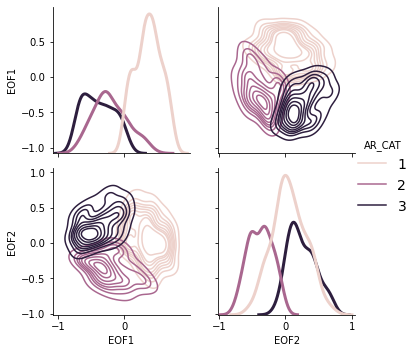

In [8]:
g = sns.PairGrid(df_out,  hue="AR_CAT", diag_sharey=False)
g.map_upper(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 3, legend = True)
g = g.add_legend(fontsize=14)

filepath = fig_path + 'hist_kde_arcat'+ '.png'
g.savefig(filepath)

In [9]:
## Separate the AR Types into multiple columns
# create a new df that breaks up the AR_CAT col so each category has its own column
keys = []
for k in range(nk):
    keys.append("AR_CAT{:1d}".format(k+1,))

values = np.zeros((len(dates_arDays)))
dicts = dict(zip(keys, values))

df_cat = pd.DataFrame(dicts, index=dates_arDays)

for k in range(nk):
    idx = (df_out['AR_CAT'] == k+1)
    col = "AR_CAT{:1d}".format(k+1,)
    df_cat.loc[idx, col] = 1

df_cat

,AR_CAT1,AR_CAT2,AR_CAT3
date,,,
1979-12-01 09:00:00,1.0,0.0,0.0
1979-12-02 09:00:00,1.0,0.0,0.0
1980-01-24 09:00:00,1.0,0.0,0.0
1980-02-12 09:00:00,1.0,0.0,0.0
1980-02-13 09:00:00,0.0,0.0,1.0
...,...,...,...
2017-02-21 09:00:00,0.0,1.0,0.0
2017-02-22 09:00:00,0.0,1.0,0.0
2017-12-05 09:00:00,0.0,0.0,1.0


In [10]:
def nearest(items, pivot):
    '''Find the nearest date in a list compared to a single date'''
    nearest=min(items, key=lambda x: abs(x - pivot))
    timedelta = nearest-pivot
    return timedelta.days

In [11]:
# List of dates that match each AR type conditions
x = []
ns = []
for k in range(nk):
    col = "AR_CAT{:1d}".format(k+1,)
    idx = (df_cat[col] > 0)
    mask = df_cat.index[idx]
    x.append(mask)
    ns.append(len(mask))
    
print(len(x[0]), len(x))

169 3


In [12]:
# calculate the number of days between Type 1 and the other types
near = []
data = []
for i in range(nk-1):
    for j in range(len(x[0])):
        t1 = x[0][j]
        t2 = pd.to_datetime(x[i+1])
        near.append(nearest(items=t2, pivot=t1))
    s = pd.Series(np.asarray(near))
    data.append(s)
        

In [13]:
# plot labels with each number of AR days in each cluster
plt_labels = []
for k in range(nk-1):
    plt_labels.append("Type {0} (n={1}) and Type {2} (n={3})".format(k+1, ns[k], k+2, ns[k+1]))
    
print(plt_labels)

['Type 1 (n=169) and Type 2 (n=93)', 'Type 2 (n=93) and Type 3 (n=93)']


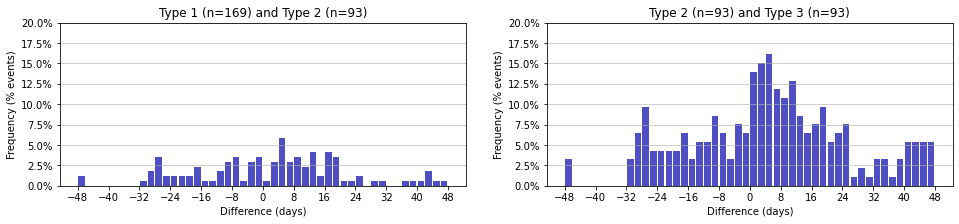

In [14]:
nrows = 1
ncols = nk-1
nplots = nrows*ncols
# Create figure
fig = plt.figure(figsize=(16,3))
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    n, bins, patches = plt.hist(x=data[i], bins=np.arange(-48, 50, 2), color='#0504aa',
                                alpha=0.7, rwidth=0.85, weights=np.ones(len(data[i])) / ns[i])
#     print(len(data[i]))
#     print(ns[i])
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=None))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Difference (days)')
    plt.xticks(np.arange(-48, 50, 8)) 
    plt.ylabel('Frequency (% events)')
    plt.title(plt_labels[i])
    plt.ylim([0, .20])

# Save figure
filepath = fig_path + 'hist_perc.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

In [15]:
df_tmp = df_cat.groupby(df_cat.index.month).sum()
df_tmp.loc[:,"Month"] = df_tmp.index
results = pd.melt(df_tmp, id_vars=['Month'], var_name='subtype', value_name='frequency')

/home/nash/DATA/repositories/AR_types/figs/HUV500/djf/neof2/k3/ARTYPE_freq_barplot.png


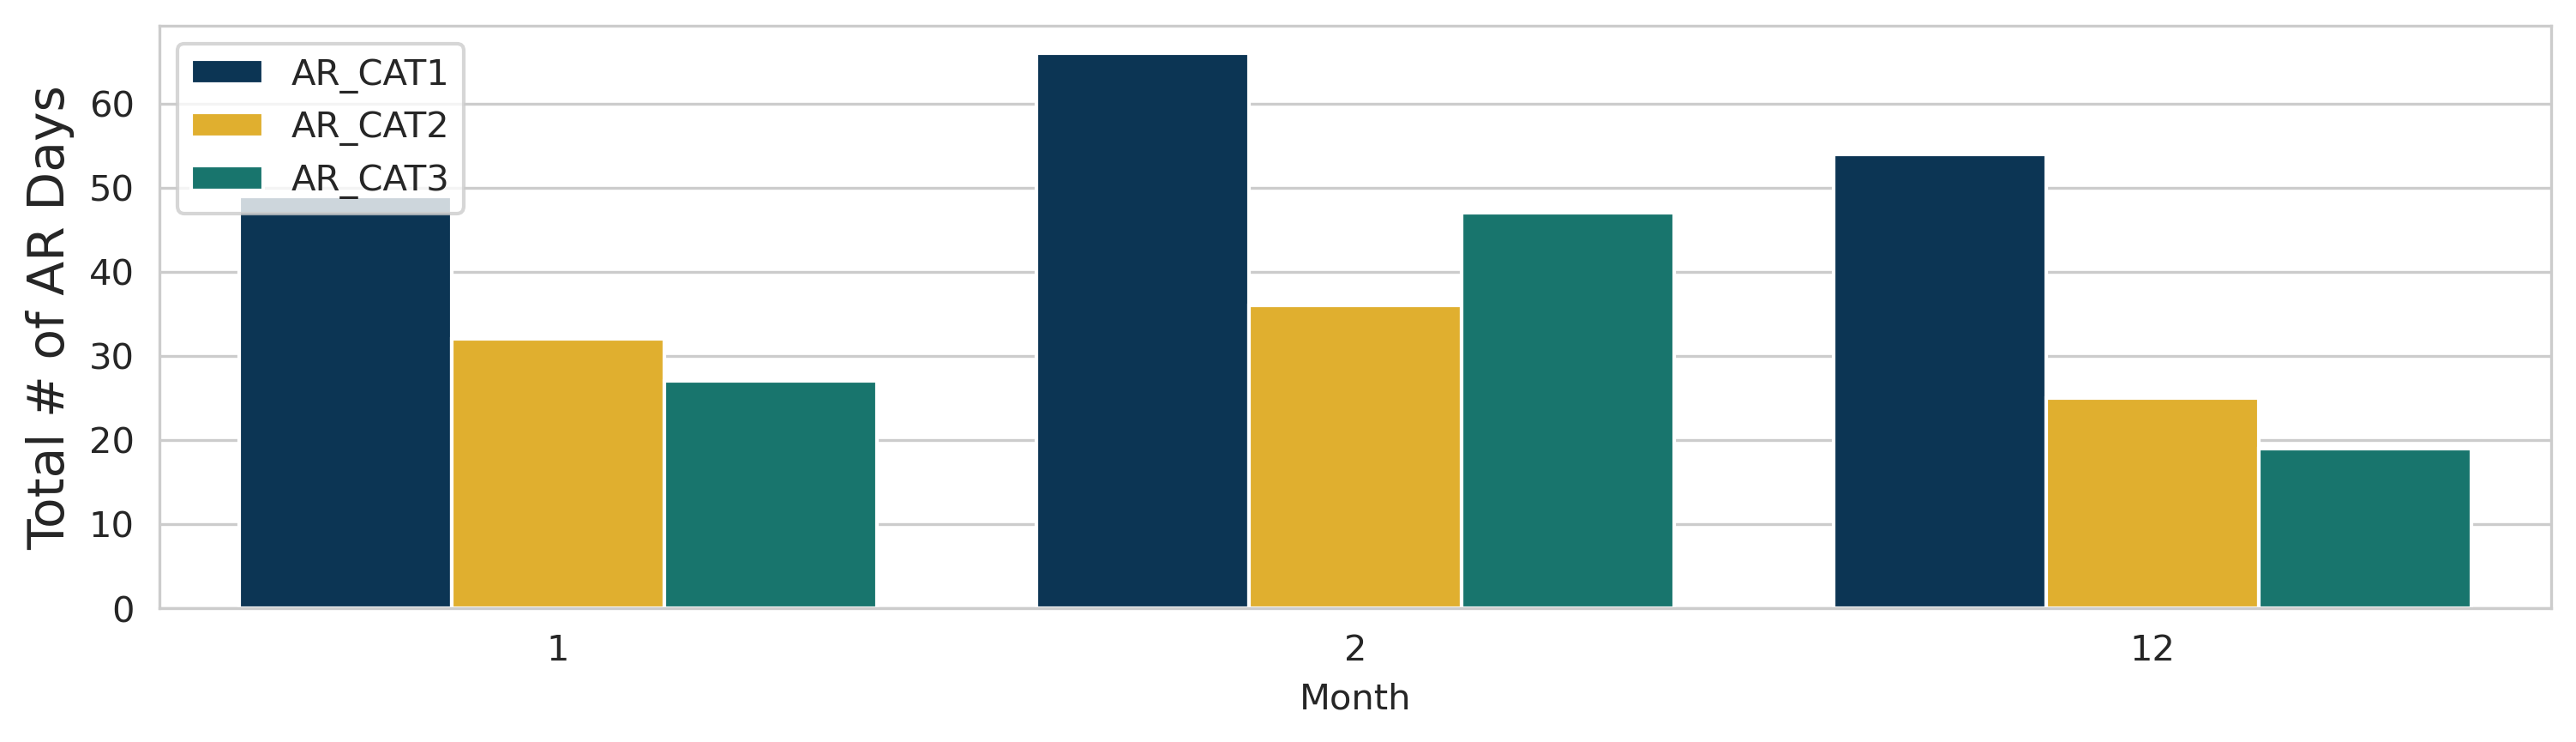

<Figure size 3600x900 with 0 Axes>

In [16]:
fname = fig_path + 'ARTYPE_freq_barplot' 
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.0,3.0))
fig.dpi = 300
nplots=1

# Set custom color palette
colors = ["#003660", "#FEBC11", "#09847A"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x='Month', y='frequency', hue='subtype', data=results)
#     ax.set_title('AR Frequency (1980-2015)', fontsize=12)
    ax.set_ylabel('Total # of AR Days', fontsize=14)
#     ax.set_xticklabels(columns, fontsize=12)
    ax.legend(loc='upper left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [17]:
# export csv of AR categories for ALL days
# import configuration file for season dictionary choice
yaml_doc = '../data/config.yml'
config1 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ar_dict = config1[ssn]

start_date = ar_dict['start_date']
end_date = ar_dict['end_date']

date_lst = df_out.index

# date array with all days
dates_allDays = pd.date_range(start=start_date, end=end_date, freq='1D')
arr_allDays = np.zeros(len(dates_allDays), dtype=np.float)

# Loop over ar days and match to ar_full 
for i, date in enumerate(date_lst):
    idx = np.where(dates_allDays == date)
    arr_allDays[idx] = 1
    
# Create dataframe
data = {col:arr_allDays}
df_all = pd.DataFrame(data, index=dates_allDays)

# Save dataframe
outfile = out_path + 'AR-types_ALLDAYS.csv'
df_all.to_csv(outfile)